# Exercise 1a)

In [587]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import Code.CreateData as cd
import Code.OrdinaryLeastSquares as ols
import Code.RidgeRegression as ridge

First I create the data. I start with no added noise.

In [284]:
#
# Make data and preprocess
#
n = 10000 # number of datapoints 
degree = 5
test_fraction = 0.2
data = cd.CreateData(n,seed=8)
#data.add_normal_noise(0,1)
data.create_design_matrix(degree)
data.split_dataset(test_fraction)
data.scale_dataset()

Now that we have the data scaled and split into training and test sets I use my implementation of OLS to perform the regression.

X:  (150, 351)
Beta:  (351,)


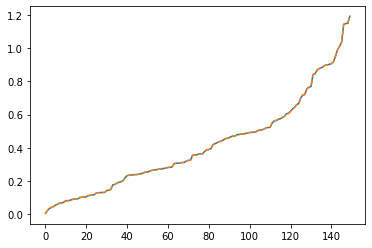

The r^2 score for this fit is: 0.9999829173951922


In [598]:
#
# Perform regression
#
OLS_model = ols.OrdinaryLeastSquares()
OLS_model.fit(data.X_train,data.z_train)

z_hat = OLS_model.predict(data.X_train)

# plotting the predicted z-values with the true values
plt.plot(np.sort(z_hat))#data.z_test,OLS_model.z_hat)
plt.plot(np.sort(data.z_train),linestyle='dashed')
plt.show()

print("The r^2 score for this fit is:", OLS_model.r2(z_hat,data.z_train))

I see we get a pretty good fit. 
Now I move on to a more thorough examination of the performance of my OLS model. I do this by examining the $r^2$ score and mean square error for the training and the test set as the model complexity increases. The model complexity is here given by $d$, the polynomial degree.

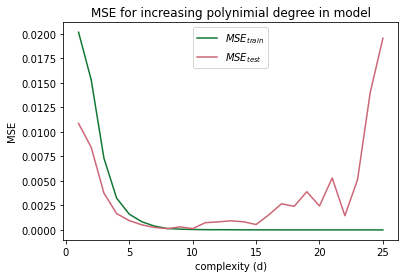

In [593]:
n = 200 # number of datapoints 
max_degree = 25
test_fraction = 0.25
data = cd.CreateData(n,seed=8)
OLS_model = ols.OrdinaryLeastSquares()

r2_scores = np.zeros((max_degree,2))
mses = np.zeros((max_degree,2))

for d in range(max_degree):
    data.create_design_matrix(d+1)
    data.split_dataset(test_fraction)
    data.scale_dataset()
    OLS_model.fit(data.X_train,data.z_train)
    z_hat_train = OLS_model.predict(data.X_train)
    z_hat_test = OLS_model.predict(data.X_test)
    
    r2_scores[d] = ([OLS_model.r2(z_hat_train,data.z_train),OLS_model.r2(z_hat_test,data.z_test)])
    mses[d] = ([OLS_model.mean_square_error(z_hat_train,data.z_train),OLS_model.mean_square_error(z_hat_test,data.z_test)])
    
d = np.arange(1,max_degree+1)
plt.plot(d,mses[:,0], color='#117733', label='$MSE_{train}$')
plt.plot(d,mses[:,1], color='#CC6677', label='$MSE_{test}$')
plt.xlabel('complexity (d)')
plt.ylabel('MSE')
plt.title('MSE for increasing polynimial degree in model')
plt.legend()

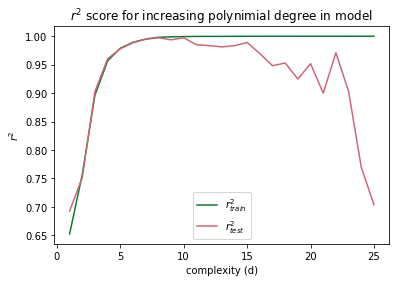

In [293]:
plt.plot(d,r2_scores[:,0], color='#117733', label='$r^2_{train}$')
plt.plot(d,r2_scores[:,1], color='#CC6677', label='$r^2_{test}$')
plt.xlabel('complexity (d)')
plt.ylabel('$r^2$')
plt.title('$r^2$ score for increasing polynimial degree in model')
plt.legend()

Now I want to find the confidence intervals of the $\beta$s.

Text(0.5, 1.0, 'The 90.0 % confidence intervals for beta')

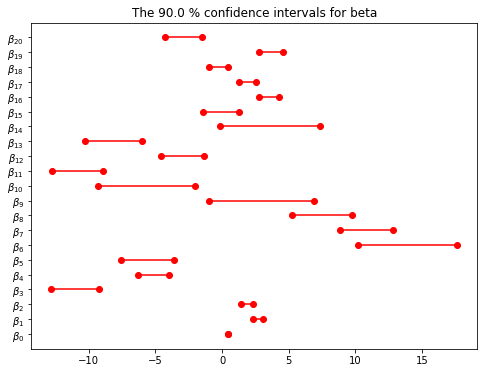

In [292]:
# see https://compphysics.github.io/MachineLearning/doc/pub/week36/html/week36.html
data.create_design_matrix(5)
data.split_dataset(test_fraction)
data.scale_dataset()
OLS_model.fit(data.X_train,data.z_train)

confidence = 0.90
CIs = OLS_model.get_beta_CIs(confidence)
fig = plt.figure(figsize=(8, 6))

beta_label = []
p = CIs.shape[0]
for i in range(p):
    beta_label.append(fr"$\beta_{{{i}}}$")
    plt.plot(CIs[i,:],(i,i), 'ro-')
plt.yticks(np.arange(p), beta_label)
plt.title(fr"The {confidence*100} % confidence intervals for beta")

# Exercise 1b)

--- Mean square error on static test set for B=1000 bootstraps. ---
d=1: MSE(test set): 0.022501 
d=2: MSE(test set): 0.015493 
d=3: MSE(test set): 0.007252 
d=4: MSE(test set): 0.003582 
d=5: MSE(test set): 0.001676 
d=6: MSE(test set): 0.001604 
d=7: MSE(test set): 0.002026 
d=8: MSE(test set): 0.004218 
d=9: MSE(test set): 0.007464 
d=10: MSE(test set): 0.022144 


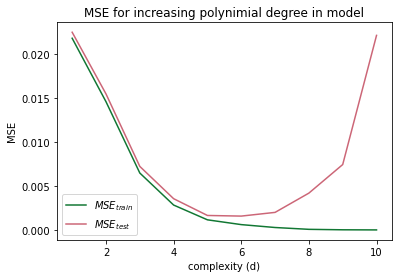

In [490]:
# Now to perform resampling in the form of bootstrapping and plotting the error as a function of complexity

# Bootstrap
B = 1000
max_degree = 10
n = 200
OLS_model = ols.OrdinaryLeastSquares()
mse_test, mse_train = OLS_model.bootstrap_fit_loop(cd,B,max_degree,n)

d = np.arange(1,max_degree+1)
fig = plt.figure(figsize=(8, 6))
plt.plot(d,mse_train, color='#117733', label='$MSE_{train}$')
plt.plot(d,mse_test, color='#CC6677', label='$MSE_{test}$')
plt.xlabel('complexity (d)')
plt.ylabel('MSE')
plt.title('MSE for increasing polynimial degree in model')
plt.legend()

In [352]:
print('The minimum MSE is: {} found for polynomial degree d = {}'.format(min(mse_test),np.argmin(mse_test)+1))

The minimum MSE is: 0.0016044872969174992 found for polynomial degree d = 6


--- Mean square error on static test set for B=1000 bootstraps. ---
d=1: MSE(test set): 0.035592 
d=2: MSE(test set): 0.033562 
d=3: MSE(test set): 0.020400 
d=4: MSE(test set): 0.016104 
d=5: MSE(test set): 0.016608 
d=6: MSE(test set): 0.018754 
d=7: MSE(test set): 0.038632 
The minimum MSE is: 0.016104384763666196 found for polynomial degree d = 4


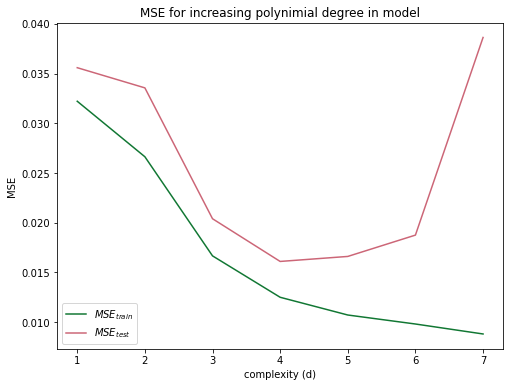

In [718]:
from sklearn.preprocessing import StandardScaler

#
# Make data
#
n = 200 # number of datapoints 
sigma_squared = 0.1
test_fraction = 0.2
test_data = cd.CreateData(n,seed=13)
train_data = cd.CreateData(n)
# add noise
test_data.add_normal_noise(0,sigma_squared)
train_data.add_normal_noise(0,sigma_squared)

# Model
OLS_model = ols.OrdinaryLeastSquares()

# Bootstrap
B = 1000
max_degree = 7

scaler = StandardScaler()

mse_bs = np.zeros((max_degree,2))
print("--- Mean square error on static test set for B=%d bootstraps. ---" %(B))
for d in range(max_degree):
    train_data.create_design_matrix(d+1)
    test_data.create_design_matrix(d+1)
    scaler.fit(train_data.X[:,1:]) # use method in data class
    X_train_scaled = scaler.transform(train_data.X[:,1:])
    X_test_scaled = scaler.transform(test_data.X[:,1:])
    train_data.X = np.hstack((np.ones((train_data.X.shape[0],1)),X_train_scaled))
    test_data.X = np.hstack((np.ones((test_data.X.shape[0],1)),X_test_scaled))
    mse_bs[d,:] = OLS_model.bootstrap_fit(train_data.X,train_data.z,test_data.X,test_data.z,B)#(data.X,data.z,B,test_fraction) # test on same data!!!
    print(f"d=%d: MSE(test set): %f " %(d+1,mse_bs[d,0]))

d_array = np.arange(1,max_degree+1)
fig = plt.figure(figsize=(8, 6))
plt.plot(d_array,mse_bs[:,1], color='#117733', label='$MSE_{train}$')
plt.plot(d_array,mse_bs[:,0], color='#CC6677', label='$MSE_{test}$')
plt.xlabel('complexity (d)')
plt.ylabel('MSE')
plt.title('MSE for increasing polynimial degree in model')
plt.legend()
print('The minimum MSE is: {} found for polynomial degree d = {}'.format(min(mse_bs[:,0]),np.argmin(mse_bs[:,0])+1))

# Exercise 1c)

k=5 - Minimum MSE=0.004030 found for d=4
k=6 - Minimum MSE=0.003194 found for d=5
k=7 - Minimum MSE=0.002467 found for d=5
k=8 - Minimum MSE=0.002094 found for d=5
k=9 - Minimum MSE=0.001968 found for d=4
k=10 - Minimum MSE=0.001698 found for d=4


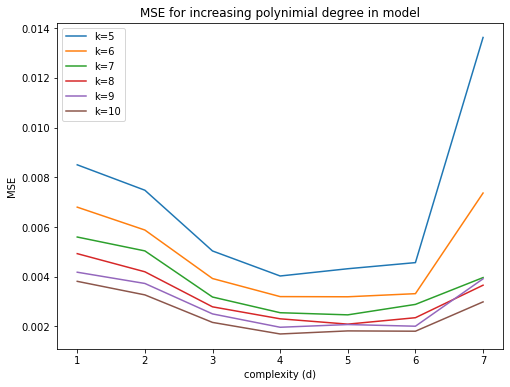

In [719]:
# Now to perform resampling in the form of k-fold cross validation

#
# Make data and preprocess
#
# Use same data as in b)
OLS_model = ols.OrdinaryLeastSquares()
# kfold CV
min_k = 5
max_k = 11
#max_degree = 10
mse_cv = np.zeros(max_degree)
i=0

mse_min = np.zeros((max_k-min_k,2))

plt.figure(figsize=(8, 6))
for k in range(min_k,max_k):
    for d in range(max_degree):
        train_data.create_design_matrix(d+1)
        mse_cv[d] = OLS_model.k_fold_cv(train_data.X,train_data.z,k,shuffle=True)
    mse_min[k-min_k,:] = (min(mse_cv),np.argmin(mse_cv)+1)
    print("k=%d - Minimum MSE=%f found for d=%d" %(k,min(mse_cv),np.argmin(mse_cv)+1))
    plt.plot(d_array,mse_cv, label=f'k={k}')

plt.xlabel('complexity (d)')
plt.ylabel('MSE')
plt.title('MSE for increasing polynimial degree in model')
plt.legend()

We see that they all have minima for a fourth or fifth order polynomimal.
# Exercise d)

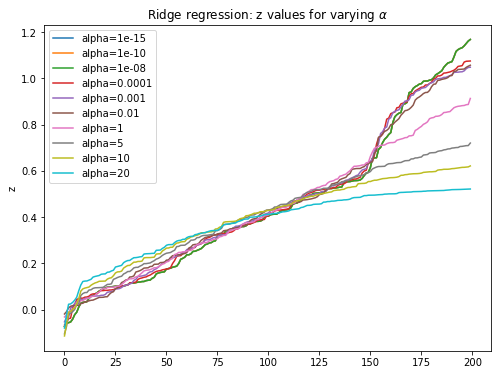

In [720]:
ridge_model = ridge.RidgeRegression()
alpha_values = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]
degree = 5
plt.figure(figsize=(8, 6))
for i in range(len(alpha_values)):
    train_data.create_design_matrix(degree)
    test_data.create_design_matrix(degree)
    z_hat_train = ridge_model.fit(train_data.X,train_data.z,alpha_values[i])
    z_hat_test = ridge_model.predict(test_data.X)

    plt.plot(np.sort(z_hat_test),label=f'alpha={alpha_values[i]}')
plt.title('Ridge regression: z values for varying $\\alpha$') 
plt.ylabel('z')
plt.legend()


    

In [701]:
reload(ols)
reload(cd)
reload(ridge)

<module 'Code.RidgeRegression' from 'C:\\Users\\emili\\Documents\\Studier\\fys-stk3155\\Exercises\\FYS-STK3155\\Project1\\Code\\RidgeRegression.py'>

MSE=0.0017457819836237218 found for alpha=1e-15
MSE=0.0016596077150456997 found for alpha=1e-14
MSE=0.0017599459679950892 found for alpha=1e-13
MSE=0.0016271414466639497 found for alpha=1e-12
MSE=0.0016682626633990206 found for alpha=1e-11
MSE=0.0016116595338549367 found for alpha=1e-10
MSE=0.0016267979685867114 found for alpha=1e-09
MSE=0.0015889616022198062 found for alpha=1e-08
MSE=0.00178272680890325 found for alpha=1e-07
MSE=0.0016267664015710143 found for alpha=1e-06
MSE=0.0016192570375321354 found for alpha=1e-05
MSE=0.0017124059690508137 found for alpha=0.0001
MSE=0.0018051152497659637 found for alpha=0.001
MSE=0.0022112561943929956 found for alpha=0.01
MSE=0.0024571097090601663 found for alpha=0.1
MSE=0.0033027734692774708 found for alpha=1.0


Text(0.5, 1.0, 'MSE for a selection of alpha values in ridge regression model')

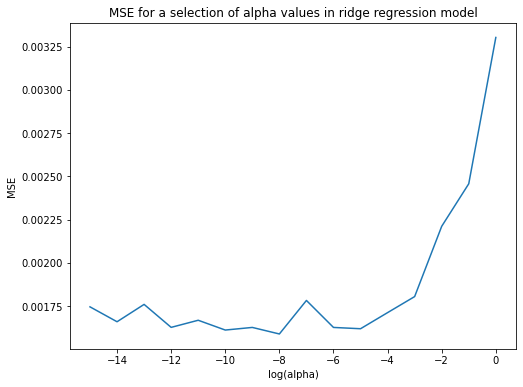

In [721]:
OLS_model = ols.OrdinaryLeastSquares()
ridge_model = ridge.RidgeRegression()
powers = np.array(range(-15,1))
ones = np.ones_like(powers)*10.0
alpha_values = np.power(ones,powers)

mse_cv_ridge = np.zeros(len(alpha_values))
plt.figure(figsize=(8, 6))
for i in range(len(alpha_values)):
    mse_cv_ridge[i] = ridge_model.k_fold_cv(train_data.X,train_data.z,k=10,alpha=alpha_values[i],shuffle=True)
    print(f"MSE={mse_cv_ridge[i]} found for alpha={alpha_values[i]}")

plt.plot(np.log10(alpha_values),mse_cv_ridge)

plt.xlabel('log(alpha)')
plt.ylabel('MSE')
plt.title('MSE for a selection of alpha values in ridge regression model')

    

[1.e-15 1.e-14 1.e-13 1.e-12 1.e-11 1.e-10 1.e-09 1.e-08 1.e-07 1.e-06
 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04
 1.e+05 1.e+06 1.e+07 1.e+08 1.e+09]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.07121e-18): result may not be accurate.
  overwrite_a=True).T
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.07121e-17): result may not be accurate.
  overwrite_a=True).T


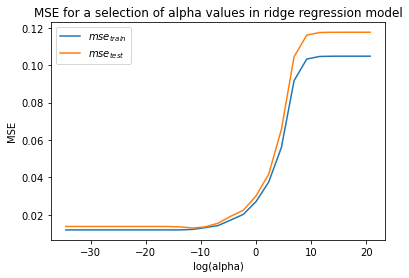

In [722]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

powers = np.array(range(-15,10))
ones = np.ones_like(powers)*10.0
alpha_values = np.power(ones,powers)
print(alpha_values)
mse_cv_ridge = np.zeros((len(alpha_values),2))
for i in range(len(alpha_values)):
    sk_ridge = Ridge(alpha=alpha_values[i])
    sk_ridge.fit(train_data.X,train_data.z)
    mse_cv_ridge[i,0] = mean_squared_error(train_data.z,sk_ridge.predict(train_data.X))
    mse_cv_ridge[i,1] = mean_squared_error(test_data.z,sk_ridge.predict(test_data.X))
    
    #print(f"MSE={mse_cv_ridge[i]} found for alpha={alpha_values[i]}")

plt.plot(np.log(alpha_values),mse_cv_ridge[:,0],label="$mse_{train}$")
plt.plot(np.log(alpha_values),mse_cv_ridge[:,1],label="$mse_{test}$")
plt.xlabel('log(alpha)')
plt.ylabel('MSE')
plt.title('MSE for a selection of alpha values in ridge regression model')
plt.legend()

#print(mse_cv_ridge)


# Exercise e)


1e-10


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2752020483599924, tolerance: 0.0020967698946070287
  positive)


1e-09


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2746673396002688, tolerance: 0.0020967698946070287
  positive)


1e-08


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2693221098808638, tolerance: 0.0020967698946070287
  positive)


1e-07


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.216062600979087, tolerance: 0.0020967698946070287
  positive)


1e-06


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7140499800836584, tolerance: 0.0020967698946070287
  positive)


1e-05
0.0001
0.001
0.01
0.1
1.0
10.0


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02557659852407701, tolerance: 0.0020967698946070287
  positive)


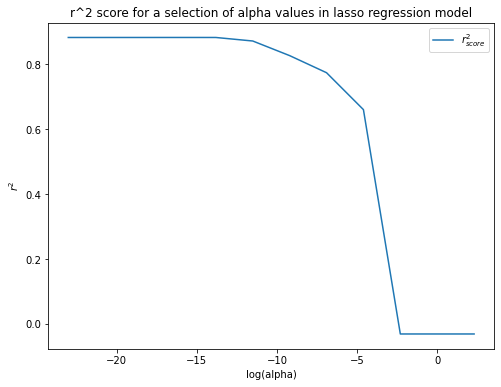

In [741]:
from sklearn.linear_model import Lasso

powers = np.array(range(-10,2))
ones = np.ones_like(powers)*10.0
alpha_values = np.power(ones,powers)

r2_score_lasso = np.zeros(len(alpha_values))
for i in range(len(alpha_values)):
    print(alpha_values[i])
    model_lasso = Lasso(alpha=alpha_values[i],max_iter=100000)
    model_lasso.fit(train_data.X,train_data.z)
    r2_score_lasso[i] = model_lasso.score(test_data.X,test_data.z)
 
plt.figure(figsize=(8, 6))
plt.plot(np.log(alpha_values),r2_score_lasso,label="$r^2_{score}$")
plt.xlabel('log(alpha)')
plt.ylabel('$r^2$')
plt.title('r^2 score for a selection of alpha values in lasso regression model')
plt.legend()


# Exercise f)

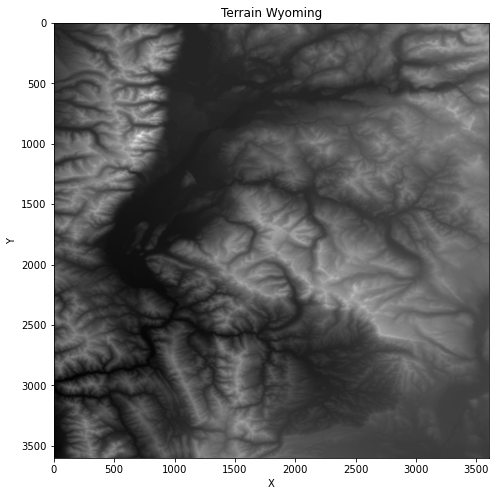

In [744]:
import numpy as np
from imageio import imread
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Load the terrain
terrain1 = imread('./Data/wyoming_grand_teton.tif')
# Show the terrain
plt.figure(figsize=(10, 8))
#plt.figure()
plt.title('Terrain Wyoming')
plt.imshow(terrain1, cmap='gray')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [289]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

lin_model = LinearRegression() # OLS
lin_model.fit(data.X_train, data.z_train)
ztilde_skl = lin_model.predict(data.X_test)
print(r2_score(ztilde_skl,data.z_test))

0.9562520966680246


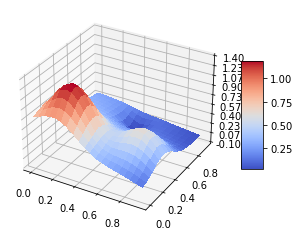

In [290]:
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed

fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)
x, y = np.meshgrid(x,y)


def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    z = term1 + term2 + term3 + term4
    return z #+ np.random.normal(0,1,z.shape)


z = FrankeFunction(x, y)

# Plot the surface.
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [291]:
n=5
x = np.random.rand(n)
y = np.random.rand(n)
x, y = np.meshgrid(x,y)
z = FrankeFunction(x, y)
z_hat = data.calculate_values(x,y)
print(z-z_hat)

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
